In [56]:
import os, shutil
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [57]:
from keras.utils import image_dataset_from_directory
IMG_SIZE = 32
train_dataset = image_dataset_from_directory(train_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)
validation_dataset = image_dataset_from_directory(validation_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)
test_dataset = image_dataset_from_directory(test_dir,label_mode='categorical',image_size=(IMG_SIZE, IMG_SIZE),batch_size=32)

Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Nesta fase do nosso código tivemos de abdicar da cama densa com L2 devido a um problema de conversão por parte do modelo de h5 para json, impedindo que o nosso modelo fosse, posteriormente, utilizado na nossa aplicação WEB.
Decidimos assim abdicar desta camada.

In [65]:
from tensorflow import keras
from keras import layers
import tensorflow as tf

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.4)(x)

x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
#x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
#x = layers.Dense(64, activation="relu")(x)
#x = layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
#x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

In [59]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_32 (Ba  (None, 32, 32, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 64)        1849

In [60]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
1250/1250 [==============================] - 34s 27ms/step - loss: 1.8842 - acc: 0.3258 - val_loss: 1.5246 - val_acc: 0.4400 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 33s 26ms/step - loss: 1.5135 - acc: 0.4480 - val_loss: 1.3794 - val_acc: 0.5116 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 35s 28ms/step - loss: 1.3602 - acc: 0.5151 - val_loss: 1.3528 - val_acc: 0.5428 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 41s 33ms/step - loss: 1.2566 - acc: 0.5559 - val_loss: 1.1822 - val_acc: 0.5814 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 45s 36ms/step - loss: 1.1735 - acc: 0.5882 - val_loss: 1.2015 - val_acc: 0.5911 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 50s 40ms/step - loss: 1.1168 - acc: 0.6086 - val_loss: 1.4923 - val_acc: 0.5610 - lr: 0.0010
Epoch 7/50
1250/1250 [==============================] - 49s 39ms/step - loss: 1.0610 - acc: 0.6307 - val_l

In [61]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)
model.save('models/projeto_2_32.h5')

313/313 [==============================] - 3s 9ms/step - loss: 0.5674 - acc: 0.8072
val_acc: 0.807200014591217


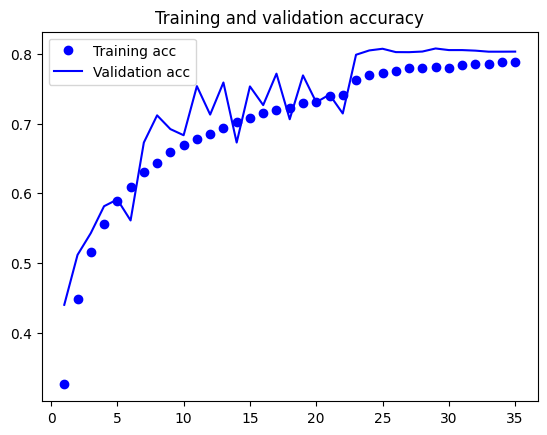

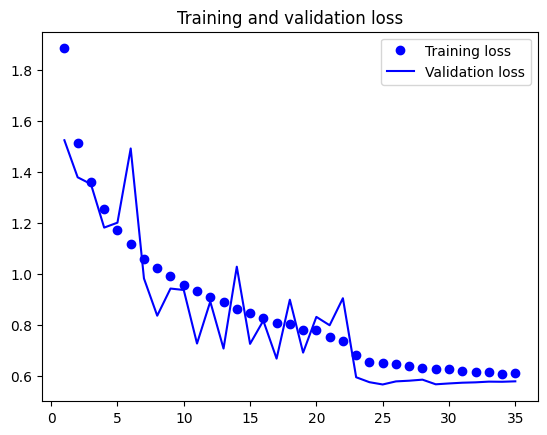

In [62]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

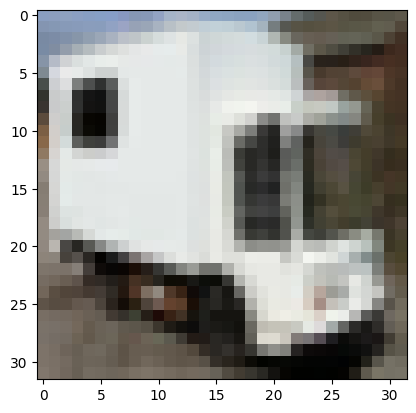

1/1 [==============================] - 0s 52ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Actual class: 009_truck ---- Predicted class: Truck
Predicted probabilities: [9.9911653e-03 1.3540968e-02 2.9375737e-03 4.4905245e-03 1.5862602e-04
 4.4518751e-03 2.6010635e-04 4.5906724e-03 1.7219324e-03 9.5785660e-01]


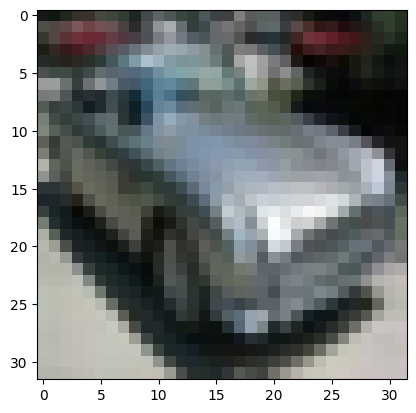

1/1 [==============================] - 0s 9ms/step
Predicted vector: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 001_automobile ---- Predicted class: Automobile
Predicted probabilities: [1.4173192e-03 9.4650471e-01 2.0946742e-03 1.9536568e-03 6.0545711e-04
 5.9479440e-04 2.4025509e-02 1.1874284e-04 2.0878203e-03 2.0597378e-02]


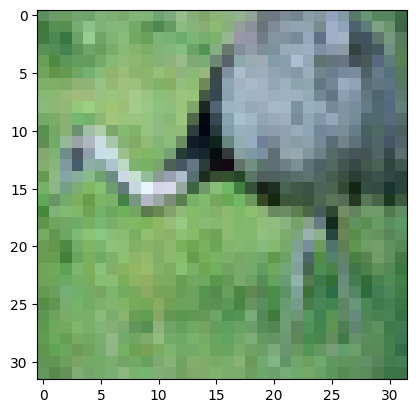

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 002_bird ---- Predicted class: Deer
Predicted probabilities: [1.1637098e-02 2.1876491e-04 1.1593139e-01 1.3290078e-02 8.3608389e-01
 5.5360985e-03 8.2794204e-03 7.6323044e-03 7.1974337e-04 6.7119772e-04]


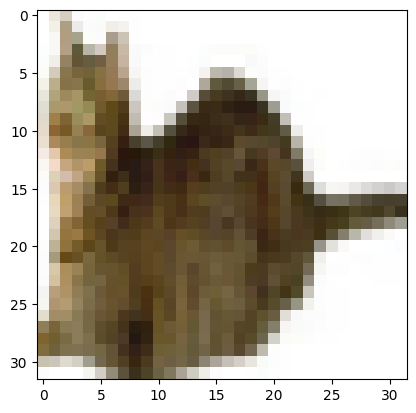

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 003_cat ---- Predicted class: Frog
Predicted probabilities: [0.01208836 0.00057493 0.08716233 0.3476028  0.00676165 0.04191978
 0.4609217  0.03035341 0.00096688 0.01164808]


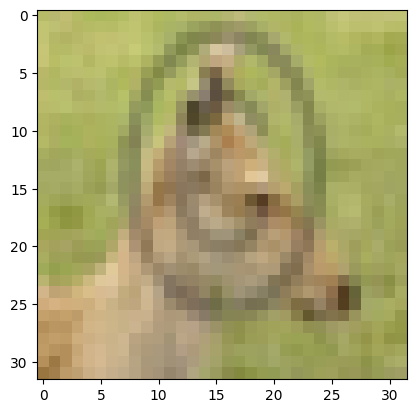

1/1 [==============================] - 0s 26ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 004_deer ---- Predicted class: Frog
Predicted probabilities: [3.6498266e-05 1.8195417e-06 2.5936484e-01 2.8751422e-02 2.8054011e-01
 4.8373775e-03 4.2616713e-01 2.5422990e-04 3.8237526e-05 8.2904417e-06]


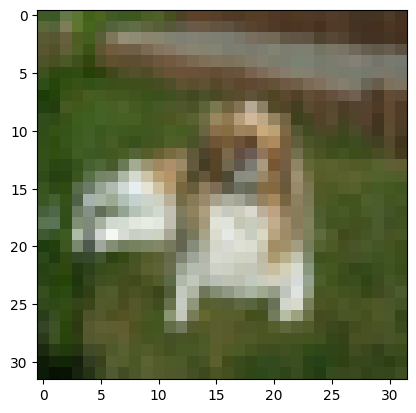

1/1 [==============================] - 0s 9ms/step
Predicted vector: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Actual class: 005_dog ---- Predicted class: Dog
Predicted probabilities: [2.2216404e-03 1.9966516e-04 1.5839319e-01 9.5366545e-02 1.3144054e-01
 3.9164934e-01 1.2665516e-01 9.1467574e-02 1.4043724e-03 1.2018948e-03]


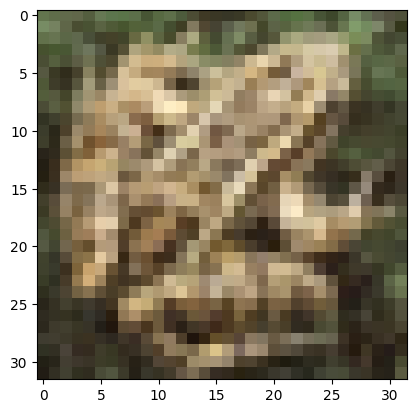

1/1 [==============================] - 0s 9ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
Actual class: 006_frog ---- Predicted class: Frog
Predicted probabilities: [1.0234577e-05 8.9297528e-06 1.4210604e-03 5.4510096e-03 5.5272593e-03
 4.9192447e-04 9.8699111e-01 5.1820851e-05 8.6585469e-06 3.7962076e-05]


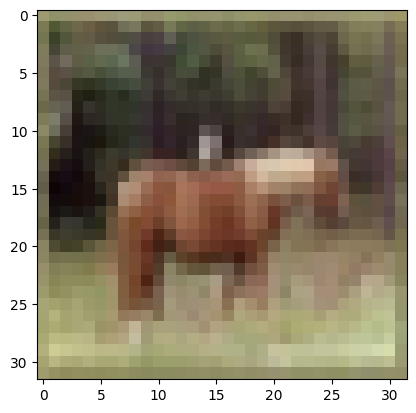

1/1 [==============================] - 0s 10ms/step
Predicted vector: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]
Actual class: 007_horse ---- Predicted class: Deer
Predicted probabilities: [2.2167582e-05 2.7490548e-06 7.5625553e-04 3.5839668e-04 8.2042712e-01
 1.7439936e-03 1.8042796e-04 1.7649561e-01 2.0539370e-07 1.2972997e-05]


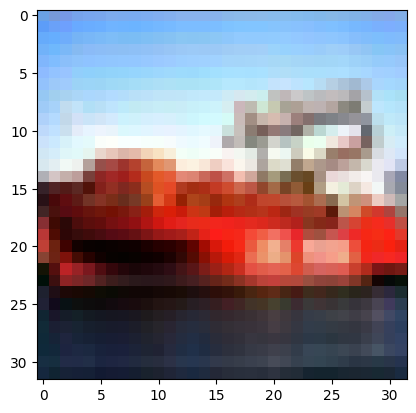

1/1 [==============================] - 0s 11ms/step
Predicted vector: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
Actual class: 008_ship ---- Predicted class: Ship
Predicted probabilities: [1.2467777e-03 7.0063729e-04 3.1679829e-06 1.3987530e-05 5.0254462e-06
 1.9185854e-06 9.9493252e-07 1.8865587e-07 9.9607760e-01 1.9497731e-03]


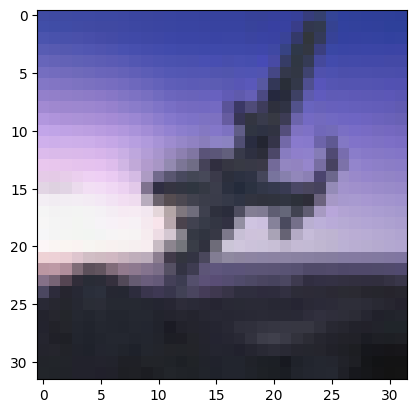

1/1 [==============================] - 0s 9ms/step
Predicted vector: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Actual class: 000_airplane ---- Predicted class: Airplane
Predicted probabilities: [0.52150536 0.0069778  0.19217323 0.01420205 0.11817766 0.00209118
 0.00937344 0.00208881 0.13149883 0.00191156]


In [63]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow import keras
import os

# Carrega o modelo salvo
model = keras.models.load_model('models/projeto_3_data_augmentation.h5')

# Função para prever a classe de uma imagem
def predict_image_class(label):
    # Diretório das imagens de treino
    img_dir = f'../train/{label}'
    
    # Lista de arquivos de imagem no diretório
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Seleciona uma imagem aleatória da lista
    random_image = random.choice(image_files)
    img_path = os.path.join(img_dir, random_image)
    
    # Carrega e exibe a imagem
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    plt.imshow(img)
    plt.show()
    
    # Prepara a imagem para a predição
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Realiza a predição
    predictions = model.predict(img_array)

    # Vetor de probabilidades estatísticas
    predicted_probabilities = predictions[0]
    
    # Determina a classe prevista
    predicted_class_index = np.argmax(predictions)
    
    # Vetor de predição
    predicted_vector = np.zeros_like(predictions)
    predicted_vector[0, predicted_class_index] = 1
    
    # Mapeamento de índices de classes para rótulos
    class_labels = {
        0: "Airplane",
        1: "Automobile",
        2: "Bird",
        3: "Cat",
        4: "Deer",
        5: "Dog",
        6: "Frog",
        7: "Horse",
        8: "Ship",
        9: "Truck"
    }
    
    # Obtém o rótulo da classe prevista
    predicted_label = class_labels[predicted_class_index]
    
    # Exibe os resultados
    print(f"Predicted vector: {predicted_vector}")
    print(f"Actual class: {label} ---- Predicted class: {predicted_label}")
    print(f"Predicted probabilities: {predicted_probabilities}")


# Lista de rótulos para prever
labels = ['009_truck', '001_automobile', '002_bird', '003_cat', '004_deer', '005_dog', '006_frog', '007_horse', '008_ship', '000_airplane']

# Realiza predições para cada rótulo na lista
for label in labels:
    predict_image_class(label)